## Crop Disease Detection Project

### Problem statement 

Crop diseases are a leading cause of reduced agricultural productivity worldwide, 
especially in regions where access to expert diagnosis is limited.
 Farmers often struggle to identify diseases early, resulting in significant 
yield loss and increased use of harmful chemicals. 
This project proposes a deep learning solution using Convolutional Neural Networks (CNNs) 
to detect and classify crop diseases from leaf images. The goal is to provide an accessible, 
image-based diagnostic tool that empowers farmers with timely, accurate disease identification.

### Objectives

1. Build a CNN model to classify crop diseases from leaf image.
2. Develop NLP methods to analyze farmers’ textual symptom descriptions.
3. Integrate CNN and NLP outputs into a single multimodal diagnostic model.
4. Compare multimodal performance to image-only and text-only models.
5. create a user-friendly app for farmers to upload photos and symptoms for instant diagnosis.

### Preprocessing

In [1]:
import os
from collections import defaultdict

data_path = "/home/margaret/Phase-4-project/PlantVillage/"

class_counts = defaultdict(int)

for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        count = len([file for file in os.listdir(class_folder) if file.endswith(('.jpg', '.png'))])
        class_counts[class_name] = count

# Print no of images per class
for cls, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {count} images")


Tomato_Late_blight: 152 images
Pepper__bell___healthy: 2 images
Tomato_healthy: 1 images
Tomato_Bacterial_spot: 0 images
Tomato__Tomato_mosaic_virus: 0 images
Tomato_Spider_mites_Two_spotted_spider_mite: 0 images
Tomato_Septoria_leaf_spot: 0 images
Potato___Early_blight: 0 images
Potato___Late_blight: 0 images
Tomato_Leaf_Mold: 0 images
Potato___healthy: 0 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 0 images
Tomato_Early_blight: 0 images
Tomato__Target_Spot: 0 images
Pepper__bell___Bacterial_spot: 0 images


This counts how many images are in each folder in the PlantVillage dataset.It also helps us to identify class imbalance

In [2]:
os.listdir(data_path)

['Tomato_Bacterial_spot',
 'Tomato__Tomato_mosaic_virus',
 'Pepper__bell___healthy',
 'Tomato_healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Septoria_leaf_spot',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Tomato_Leaf_Mold',
 'Potato___healthy',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Pepper__bell___Bacterial_spot']

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

Displaying: /home/margaret/Phase-4-project/PlantVillage/Tomato_Late_blight/bd9341f4-34d9-4acb-9aa0-5dbff08f8ba6___GHLB_PS Leaf 23 Day 9.jpg


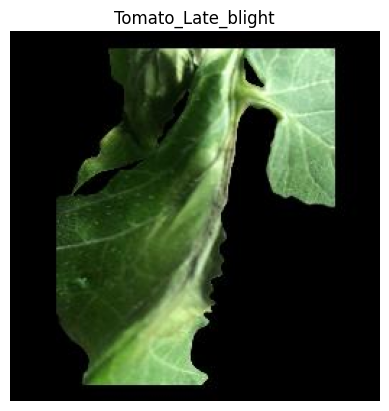

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

data_path = "/home/margaret/Phase-4-project/PlantVillage"
class_name = "Tomato_Late_blight"

folder = os.path.join(data_path, class_name)
images = [img for img in os.listdir(folder) if img.endswith(('.jpg', '.png'))]
img_path = os.path.join(folder, random.choice(images))

print("Displaying:", img_path)

img = Image.open(img_path).convert('RGB')

plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


### EDA

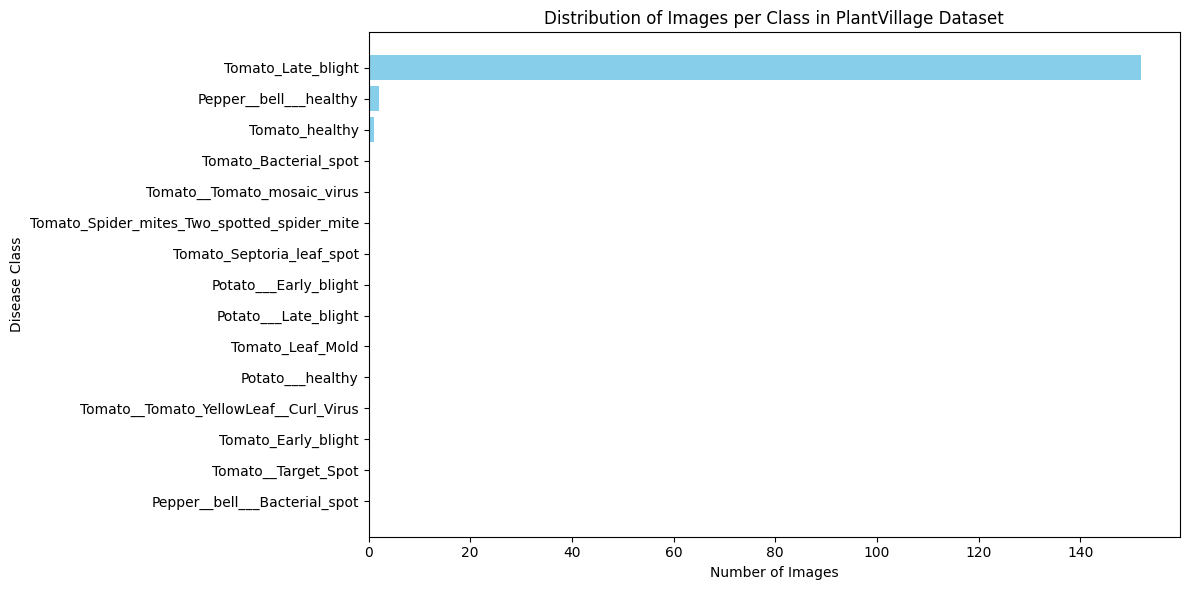

In [5]:
import matplotlib.pyplot as plt

# Sort class counts by number of images
sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
classes = [item[0] for item in sorted_counts]
counts = [item[1] for item in sorted_counts]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(classes, counts, color="skyblue")
plt.xlabel("Number of Images")
plt.ylabel("Disease Class")
plt.title("Distribution of Images per Class in PlantVillage Dataset")
plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()


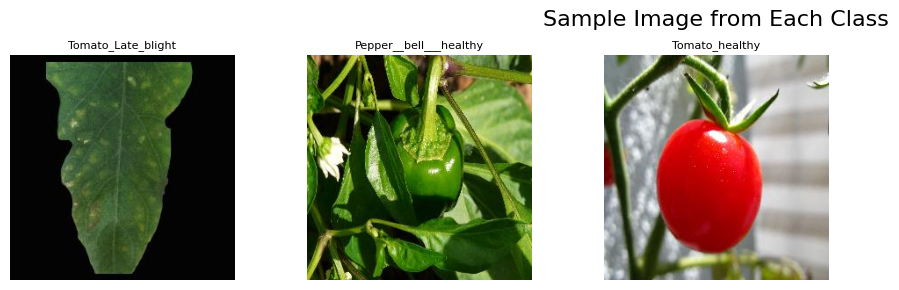

In [6]:
from PIL import Image

n_classes = len(classes)
cols = 5
rows = (n_classes + cols - 1) // cols

plt.figure(figsize=(15, rows * 2.5))

for i, class_name in enumerate(classes):
    class_folder = os.path.join(data_path, class_name)
    image_files = [f for f in os.listdir(class_folder) if f.endswith(('.jpg', '.png'))]
    if not image_files:
        continue
    img_path = os.path.join(class_folder, image_files[0])  # first image in folder
    img = Image.open(img_path).convert("RGB")
    
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Sample Image from Each Class", fontsize=16, y=1.02)
plt.show()


/tmp/ipykernel_8358/3390345192.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_counts, y=top_classes, palette="viridis")


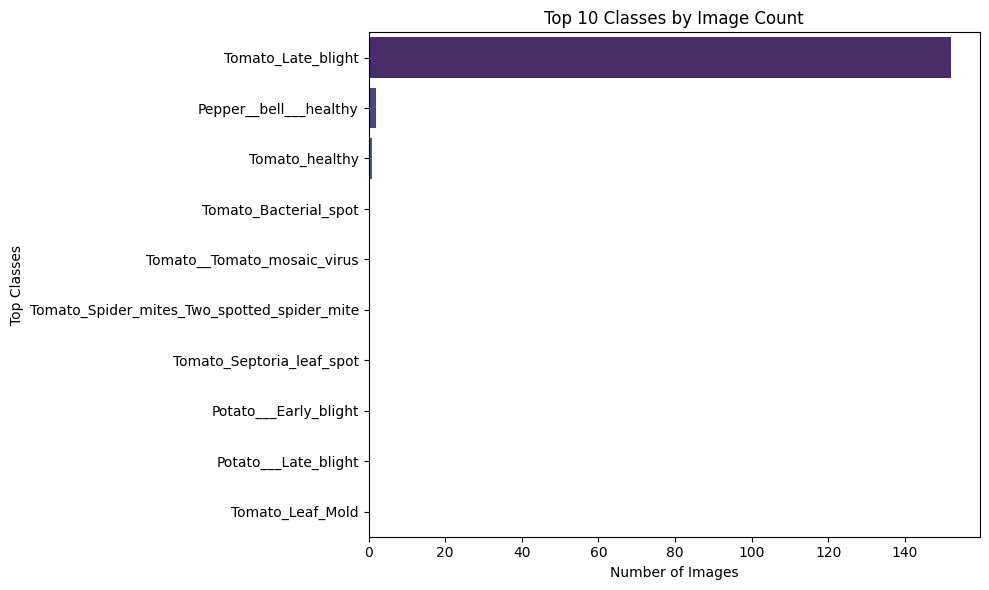

In [7]:
import seaborn as sns

top_n = 10  # Show top 10 classes
top_classes = classes[:top_n]
top_counts = counts[:top_n]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_counts, y=top_classes, palette="viridis")
plt.xlabel("Number of Images")
plt.ylabel("Top Classes")
plt.title("Top 10 Classes by Image Count")
plt.tight_layout()
plt.show()


### Modeling

In [8]:
import time
import warnings 
warnings.filterwarnings('ignore')
import random
import numpy as np
import tensorflow as tf

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

2025-07-16 12:08:02.359345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 12:08:02.591336: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 12:08:02.829248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752656883.034375    8358 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752656883.094318    8358 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752656883.509699    8358 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import os


In [10]:
data_dir = "/home/margaret/Phase-4-project/PlantVillage/"
img_size = 224 
batch_size = 32


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [12]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
#Frezzing
base_model.trainable = False  

#Adding some layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation='softmax')  
])


2025-07-16 12:08:12.541363: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [14]:
steps_per_epoch = 50  
validation_steps = 10

In [15]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=3 
)    

Epoch 1/3


2025-07-16 12:08:18.871009: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-07-16 12:08:18.945663: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 51380224 exceeds 10% of free system memory.
2025-07-16 12:08:18.989558: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-07-16 12:08:19.011265: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-07-16 12:08:19.118264: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.2946 - loss: 2.2799 - val_accuracy: 0.7063 - val_loss: 1.0769
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6661 - loss: 1.1438 - val_accuracy: 0.7969 - val_loss: 0.7131
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 990ms/step - accuracy: 0.7329 - loss: 0.8531 - val_accuracy: 0.7656 - val_loss: 0.6587


In [19]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 104s 806ms/step - accuracy: 0.7900 - loss: 0.6554
Validation Accuracy: 0.7863
Validation Loss: 0.6612


#### Insights

- Training accuracy improved steadily from 29.46% to 72.52%, indicating that the model is learning well.

- Validation accuracy also increased, showing that the model is generalizing better with each epoch.

- Both training and validation loss decreased consistently, which shows that the model is not overfitting.




In [ ]:
#Fitting the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs= 10
)


/home/margaret/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-07-15 13:35:21.662500: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-07-15 13:35:22.615679: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


  1/517 ━━━━━━━━━━━━━━━━━━━━ 2:46:14 19s/step - accuracy: 0.1562 - loss: 3.1845

2025-07-15 13:35:25.371018: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.
2025-07-15 13:35:25.694471: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 156905472 exceeds 10% of free system memory.


  2/517 ━━━━━━━━━━━━━━━━━━━━ 26:53 3s/step - accuracy: 0.1562 - loss: 3.1093   

2025-07-15 13:35:28.353655: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154140672 exceeds 10% of free system memory.


425/517 ━━━━━━━━━━━━━━━━━━━━ 4:44 3s/step - accuracy: 0.6090 - loss: 1.2576

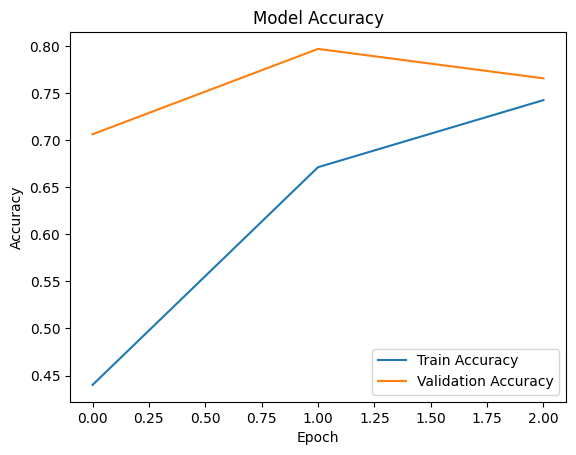

In [21]:
#Plotting accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

This graph shows how the model's classification accuracy changes over time for both the training and validation sets.

 - The steady increase in accuracy indicates that model is learning

 - The large gap between training and validation accuracy may suggest overfitting.




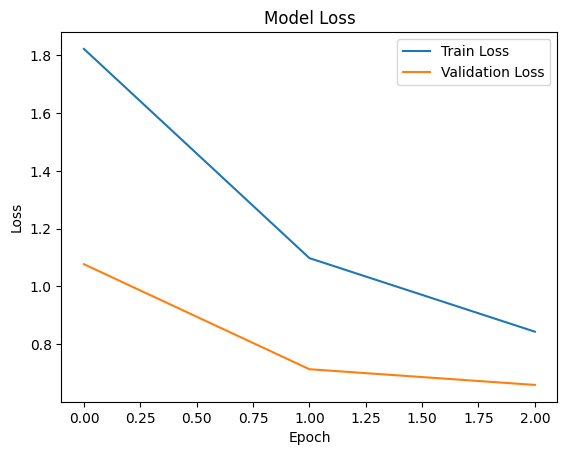

In [22]:
# Plotting loss 
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This graph tracks the model's loss over epochs.

 - Loss measures how wrong the model's predictions are.

 - A good model will show decreasing loss values over time.


### NLP

In [23]:
# Take one batch from validation set
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    
    # Get predicted classes
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    
    print("Predicted:", predicted_classes)
    print("Actual:", true_classes)

NameError: name 'val_ds' is not defined

### NLP

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('synthetic_data.csv')
df.head()

,description,crop,status,disease,recommended_pesticide
0,Visual check indicates: notable Leaf edges rem...,Potato,Healthy,healthy,NaN
1,Farmer reports: severe Leaf edges turn brown a...,Pepper_bell,Unhealthy,Bacterial_spot,Biological predators
2,sporadic New leaves become infected almost ove...,Potato,Unhealthy,Late_blight,Sulfur spray
3,Field observation shows: moderate Spots develo...,Tomato,Unhealthy,Target_Spot,Bacillus subtilis
4,Farmer complains: notable Leaves turn bronze a...,Tomato,Unhealthy,Spider_mites_Two_spotted_spider_mite,Sulfur spray


In [26]:
df.describe()

,description,crop,status,disease,recommended_pesticide
count,1750,1750,1750,1750,1429
unique,1736,3,2,10,5
top,severe Leaves collapse suddenly without warning.,Tomato,Unhealthy,healthy,Sulfur spray
freq,2,1196,1429,321,457


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            1750 non-null   object
 1   crop                   1750 non-null   object
 2   status                 1750 non-null   object
 3   disease                1750 non-null   object
 4   recommended_pesticide  1429 non-null   object
dtypes: object(5)
memory usage: 68.5+ KB


In [28]:
df.isnull().sum()

description                0
crop                       0
status                     0
disease                    0
recommended_pesticide    321
dtype: int64

In [29]:
df['recommended_pesticide'] = df['recommended_pesticide'].fillna("no recommeded pesticide")
df.isnull().sum

<bound method DataFrame.sum of       description   crop  status  disease  recommended_pesticide
0           False  False   False    False                  False
1           False  False   False    False                  False
2           False  False   False    False                  False
3           False  False   False    False                  False
4           False  False   False    False                  False
...           ...    ...     ...      ...                    ...
1745        False  False   False    False                  False
1746        False  False   False    False                  False
1747        False  False   False    False                  False
1748        False  False   False    False                  False
1749        False  False   False    False                  False

[1750 rows x 5 columns]>

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            1750 non-null   object
 1   crop                   1750 non-null   object
 2   status                 1750 non-null   object
 3   disease                1750 non-null   object
 4   recommended_pesticide  1750 non-null   object
dtypes: object(5)
memory usage: 68.5+ KB


In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [32]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [34]:
print(df.columns)


Index(['description', 'crop', 'status', 'disease', 'recommended_pesticide'], dtype='object')


In [35]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['disease'])

In [39]:
## Tokenzing
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(df['description'])

sequences = tokenizer.texts_to_sequences(df['description'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=20)

In [40]:
X = padded_sequences
y = df['label'].values #Adding labels to X and y


In [41]:
print("Input shape:", X.shape)
print("Output shape:", y.shape)


Input shape: (1750, 20)
Output shape: (1750,)


In [43]:
df['disease'].unique()

array(['healthy', 'Bacterial_spot', 'Late_blight', 'Target_Spot',
       'Spider_mites_Two_spotted_spider_mite', 'Early_blight',
       'Septoria_leaf_spot', 'Leaf_Mold', 'Tomato_YellowLeaf_Curl_Virus',
       'Tomato_mosaic_virus'], dtype=object)

In [44]:
# Adding model hyperparameters
vocab_size = 1000        
embedding_dim = 16  
max_length = 30
num_classes = len(label_encoder.classes_)

In [46]:
#Nlp model
model_nlp = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [48]:
# Compile the model
model_nlp.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [50]:
history_nlp = model_nlp.fit(X, y,epochs=20,validation_split=0.2) #Training the model


Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9561 - loss: 0.1436 - val_accuracy: 0.9629 - val_loss: 0.1343
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9872 - loss: 0.0369 - val_accuracy: 0.9800 - val_loss: 0.0763
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9967 - loss: 0.0131 - val_accuracy: 0.9914 - val_loss: 0.0362
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9943 - val_loss: 0.0112
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.9914 - val_loss: 0.0189
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9914 - val_loss: 0.0173
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9914 - val_loss: 0.0184
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9914 - val_loss:

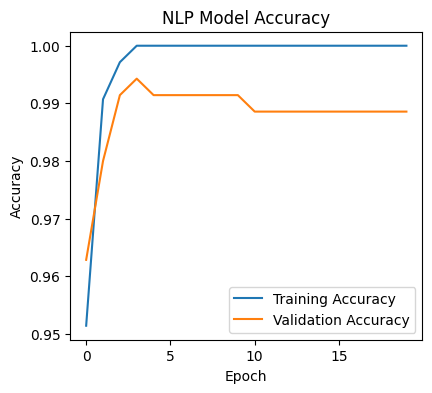

In [55]:
#Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_nlp.history['accuracy'], label='Training Accuracy')
plt.plot(history_nlp.history['val_accuracy'], label='Validation Accuracy')
plt.title('NLP Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

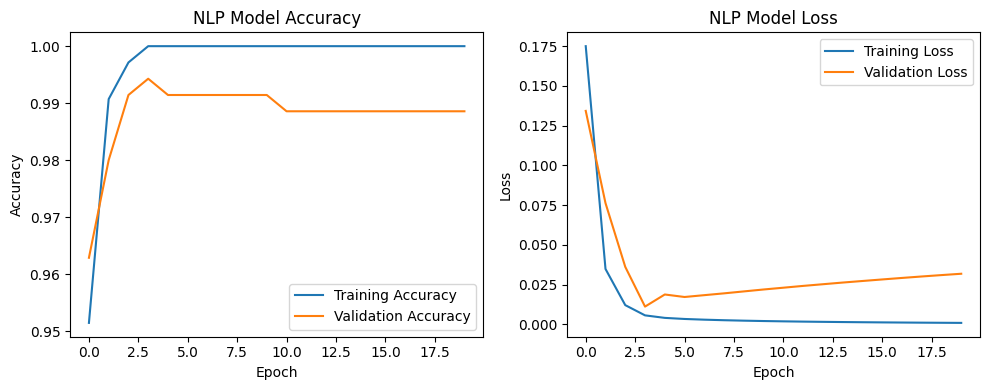

1

In [52]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_nlp.history['loss'], label='Training Loss')
plt.plot(history_nlp.history['val_loss'], label='Validation Loss')
plt.title('NLP Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()